### Load Modules

In [1]:
#Loading libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

### Load Data

In [2]:
#loading data
data = pd.read_csv('nyc-rolling-sales.csv')
data = data[data.columns[1:]]

data.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633,6440,1900,2,C2,6625000,7/19/17
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616,18690,1900,2,C7,-,12/14/16
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212,7803,1900,2,C7,-,12/9/16
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,NaN,C4,154 EAST 7TH STREET,,...,10,0,10,2272,6794,1913,2,C4,3936272,9/23/16
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369,4615,1900,2,C2,8000000,11/17/16


## Data Exploration and Preprocessing
### Data Types and Data Frame Dimensions

In [3]:
print ('The data has {0} rows and {1} columns\n'.format(data.shape[0],data.shape[1]))

print("The data type of our features:\n",
     data.dtypes)

The data has 84548 rows and 21 columns

The data type of our features:
 BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object


### Missing Value and Outliers

#### 1. Drop columns with over 60% missing value:

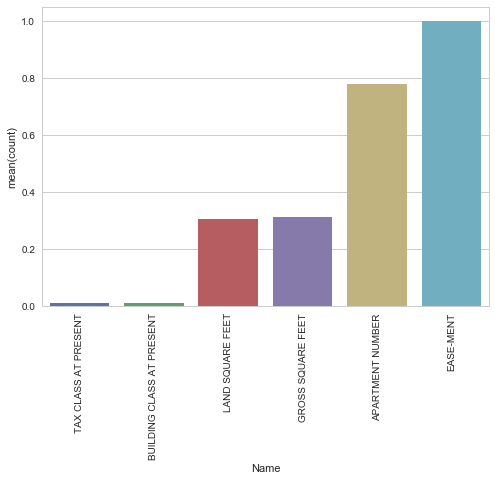

In [4]:
#check missing values
data.isnull().any()

# Change " -  ", " ", 0 into missing values:
data = data.replace(' -  ',np.nan)
data = data.replace(' ',np.nan)
data['YEAR BUILT'] = data['YEAR BUILT'].replace('0',np.nan)

# Drop rows with missing target values:
data = data.dropna(axis=0,subset=['SALE PRICE'])

#missing value counts in each of these columns
miss = data.isnull().sum()/len(data)
miss = miss[miss > 0]
miss.sort_values(inplace=True)

#visualising missing values
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
sns.plt.show()

# Drop columns with over 60% missing value:
del data['EASE-MENT']
del data['APARTMENT NUMBER']

#### 2. Convert the data into the correct datatype

In [5]:
import dateutil
data['SALE PRICE'] = data['SALE PRICE'].astype(float)
data['LAND SQUARE FEET'] = data['LAND SQUARE FEET'].astype(float)
data['GROSS SQUARE FEET'] = data['GROSS SQUARE FEET'].astype(float)
data['BOROUGH'] = data['BOROUGH'].astype('category')
data['BLOCK'] = data['BLOCK'].astype('category')
data['YEAR BUILT'] = data['YEAR BUILT'].astype('category')
data['ZIP CODE'] = data['ZIP CODE'].astype('category')
data['TAX CLASS AT TIME OF SALE'] = data['TAX CLASS AT TIME OF SALE'].astype('category')
data['SALE DATE'] = data['SALE DATE'].apply(lambda x: dateutil.parser.parse(x).month).astype('category')

data['BUILDING CLASS AT TIME OF SALE'] = data['BUILDING CLASS AT TIME OF SALE'].astype('category')
data['NEIGHBORHOOD'] = data['NEIGHBORHOOD'].astype('category')
data['BUILDING CLASS CATEGORY'] = data['BUILDING CLASS CATEGORY'].astype('category')
data['TAX CLASS AT PRESENT'] = data['TAX CLASS AT PRESENT'].astype('category')
data['BUILDING CLASS AT PRESENT'] = data['BUILDING CLASS AT PRESENT'].astype('category')
data['ADDRESS'] = data['ADDRESS'].astype('category')

#### 3. Drop rows with outliers

In [6]:
#now transforming the target variable
data['SALE PRICE'].describe()
data['SALE PRICE'] = data['SALE PRICE'].replace(0,np.nan)

# Drop rows with outliers in target variable (0, 1, 10)
data = data[data['SALE PRICE'] > 10]
data['SALE PRICE'].describe()

count    5.885200e+04
mean     1.517966e+06
std      1.242277e+07
min      1.900000e+01
25%      3.800000e+05
50%      6.350000e+05
75%      1.090000e+06
max      2.210000e+09
Name: SALE PRICE, dtype: float64

#### 4. Separate features into numerical group and catigorical group

In [7]:
#separate variables into new data frames
num_data = data.select_dtypes(include=[np.number])
del num_data['SALE PRICE']


cat_data = data.select_dtypes(exclude=[np.number])

# Drop categorical column with too many unique key:
del cat_data['ADDRESS']
print ("There are {} numeric and {} categorical columns in train data".format(num_data.shape[1],cat_data.shape[1]))



There are 6 numeric and 11 categorical columns in train data


#### 5. Fill in the missing values for the features:

In [8]:
## Fill in the missing values for the features:
 
# check which features have missing data, and how many
print(num_data.isnull().sum())
print(cat_data.isnull().sum())

# for numerical features, fill in with median
num_data['LAND SQUARE FEET'] = num_data['LAND SQUARE FEET'].fillna(
        num_data['LAND SQUARE FEET'].mean())
num_data['GROSS SQUARE FEET'] = num_data['GROSS SQUARE FEET'].fillna(
        num_data['GROSS SQUARE FEET'].mean())
# For categorical features, fill in with mode;

cat_data['BUILDING CLASS AT PRESENT'] = cat_data['BUILDING CLASS AT PRESENT'].fillna(cat_data['BUILDING CLASS AT PRESENT'].mode()[0])
cat_data['TAX CLASS AT PRESENT'] = cat_data['TAX CLASS AT PRESENT'].fillna(cat_data['TAX CLASS AT PRESENT'].mode()[0])
cat_data['YEAR BUILT'] = cat_data['YEAR BUILT'].fillna(cat_data['YEAR BUILT'].mode()[0])

print(num_data.isnull().sum())
print(cat_data.isnull().sum())

LOT                      0
RESIDENTIAL UNITS        0
COMMERCIAL UNITS         0
TOTAL UNITS              0
LAND SQUARE FEET     21051
GROSS SQUARE FEET    21592
dtype: int64
BOROUGH                             0
NEIGHBORHOOD                        0
BUILDING CLASS CATEGORY             0
TAX CLASS AT PRESENT              593
BLOCK                               0
BUILDING CLASS AT PRESENT         593
ZIP CODE                            0
YEAR BUILT                          0
TAX CLASS AT TIME OF SALE           0
BUILDING CLASS AT TIME OF SALE      0
SALE DATE                           0
dtype: int64


/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

LOT                  0
RESIDENTIAL UNITS    0
COMMERCIAL UNITS     0
TOTAL UNITS          0
LAND SQUARE FEET     0
GROSS SQUARE FEET    0
dtype: int64
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
BUILDING CLASS AT PRESENT         0
ZIP CODE                          0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE DATE                         0
dtype: int64


### Check the skewness of the target variable 

114.14317554070681

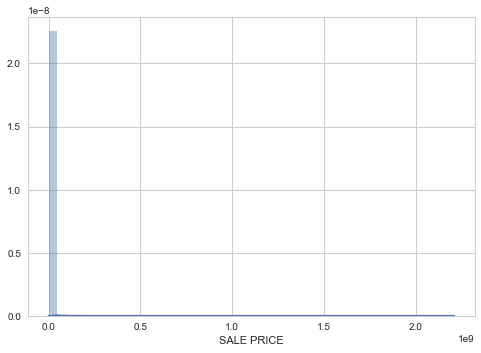

In [9]:
#SalePrice
sns.distplot(data['SALE PRICE'])
#skewness
data['SALE PRICE'].skew()

Skewness is -1.04670525231


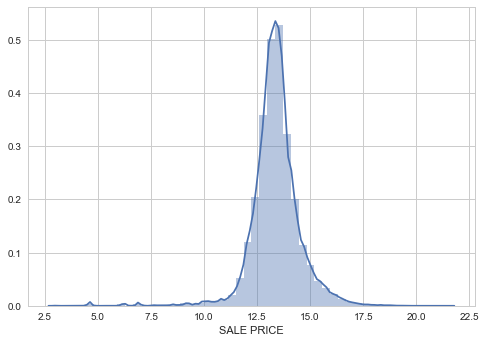

In [10]:
#transform the target variable 
target = np.log(data['SALE PRICE'])
print ('Skewness is', target.skew())
sns.distplot(target)

## Data Exploratory Analysis

### For numerical features

### Pearson Correlation Matrix

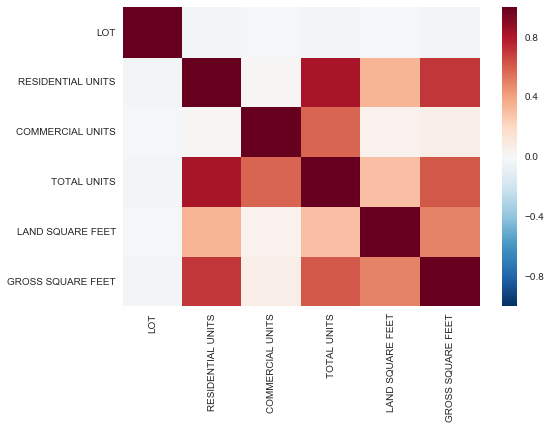

In [11]:
#correlation plot
corr = num_data.corr()
sns.heatmap(corr)

In [12]:
num_data.corr()


,LOT,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET
LOT,1.000000,-0.030348,-0.008569,-0.028643,-0.015122,-0.023517
RESIDENTIAL UNITS,-0.030348,1.000000,0.013309,0.821788,0.340577,0.715606
COMMERCIAL UNITS,-0.008569,0.013309,1.000000,0.580636,0.040825,0.066066
TOTAL UNITS,-0.028643,0.821788,0.580636,1.000000,0.300570,0.620328
LAND SQUARE FEET,-0.015122,0.340577,0.040825,0.300570,1.000000,0.494148
GROSS SQUARE FEET,-0.023517,0.715606,0.066066,0.620328,0.494148,1.000000


In [13]:
#delete correlatin > 0.7
del num_data['RESIDENTIAL UNITS']
num_data.corr()


,LOT,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET
LOT,1.000000,-0.008569,-0.028643,-0.015122,-0.023517
COMMERCIAL UNITS,-0.008569,1.000000,0.580636,0.040825,0.066066
TOTAL UNITS,-0.028643,0.580636,1.000000,0.300570,0.620328
LAND SQUARE FEET,-0.015122,0.040825,0.300570,1.000000,0.494148
GROSS SQUARE FEET,-0.023517,0.066066,0.620328,0.494148,1.000000


### Scatterplot Matrix

/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


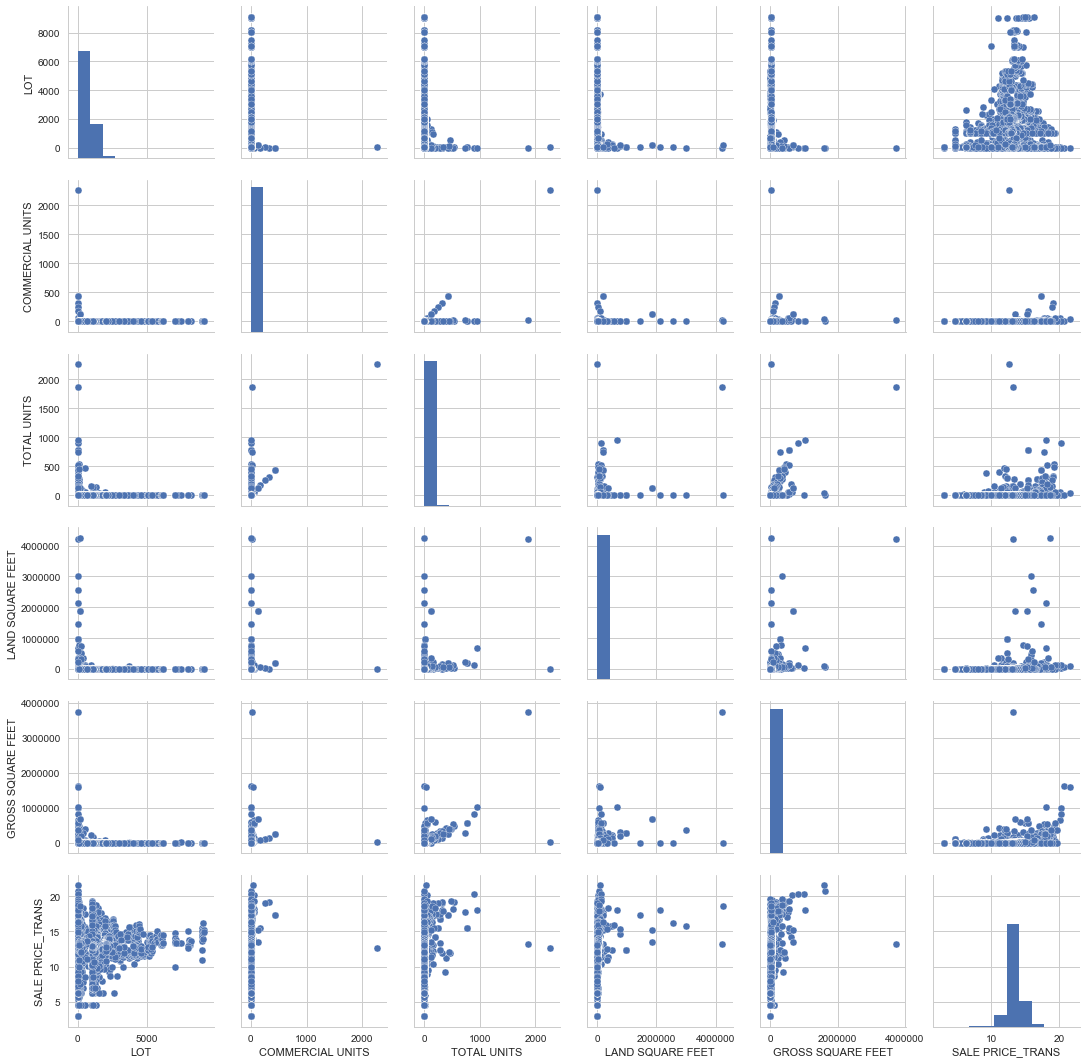

In [14]:
##plot the scatter plot matrix 
num_data['SALE PRICE_TRANS'] = target.values
sns.pairplot(num_data)

In [15]:
del num_data['SALE PRICE_TRANS']

### Box Plot

/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


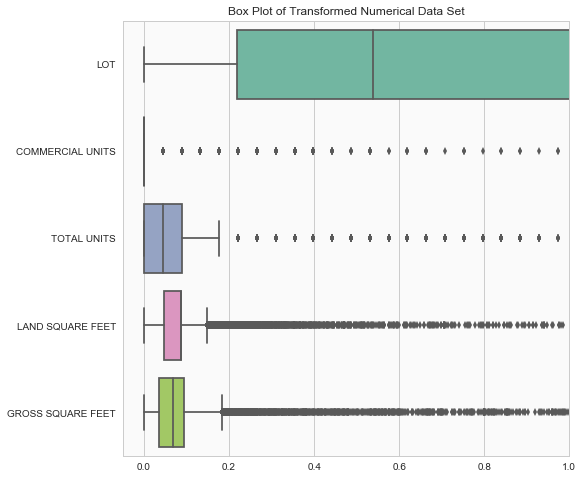

In [16]:
#numerical data
# From helperFunction script 
def normalize_df(frame):
	Norm = pd.DataFrame()
	for item in frame:
		
			Norm[item] = 100 * ((frame[item] - frame[item].min()) / 
			(frame[item].max() - frame[item].min()))

		
	return Norm

Norm = normalize_df(num_data)

#plot
f, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_bgcolor('#fafafa')
plt.title("Box Plot of Transformed Numerical Data Set")
ax.set(xlim=(-.05, 1))
ax = sns.boxplot(data = Norm, 
  orient = 'h', 
  palette = 'Set2')
#num_data.head(10)


In [17]:
#delete rows that columns have so many outliers
from scipy import stats
num_data[(np.abs(stats.zscore(num_data)) < 3).all(axis=1)]
num_data.head(10)

,LOT,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET
0,6,0,5,1633.000000,6440.000000
3,21,0,10,2272.000000,6794.000000
4,55,0,6,2369.000000,4615.000000
6,32,0,8,1750.000000,4226.000000
9,153,0,24,4489.000000,18523.000000
11,21,0,10,3717.000000,12350.000000
13,40,0,0,3703.429989,3530.473698
15,40,0,0,3703.429989,3530.473698
16,40,0,0,3703.429989,3530.473698
17,46,0,0,3703.429989,3530.473698


### For categorical features

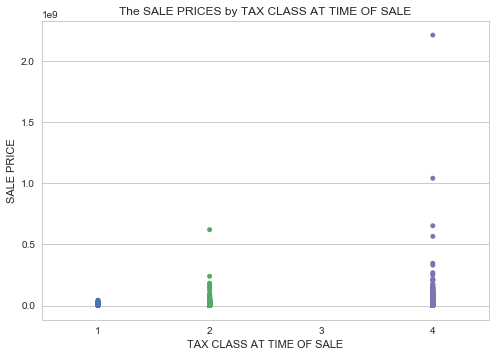

In [18]:
#Categorical data
plt.title("The SALE PRICES by TAX CLASS AT TIME OF SALE")
sns.stripplot(x="TAX CLASS AT TIME OF SALE", y="SALE PRICE", data=data);

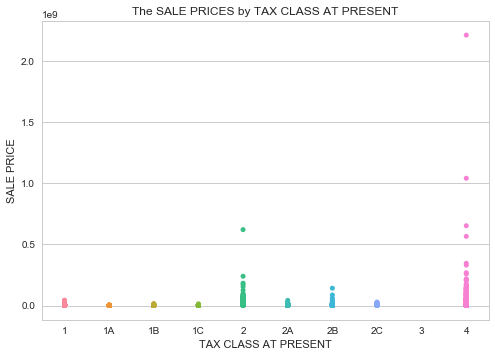

In [19]:
plt.title("The SALE PRICES by TAX CLASS AT PRESENT")

sns.stripplot(x="TAX CLASS AT PRESENT", y="SALE PRICE", data=data); 

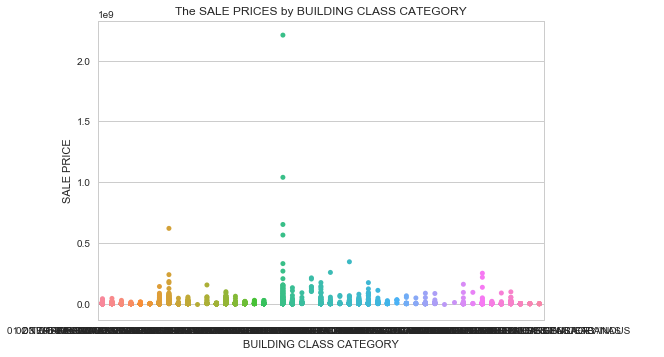

In [20]:
plt.title("The SALE PRICES by BUILDING CLASS CATEGORY")
sns.stripplot(x="BUILDING CLASS CATEGORY", y="SALE PRICE", data=data);


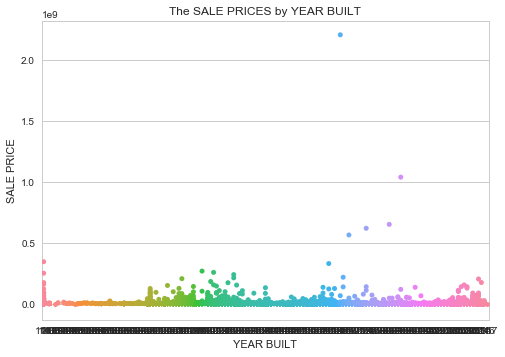

In [21]:
plt.title("The SALE PRICES by YEAR BUILT")
sns.stripplot(x="YEAR BUILT", y="SALE PRICE", data=data);


## Model Training and Evaluation

### Data preprocessing for sklearn model

In [22]:
# Encode the categorical features
le = preprocessing.LabelEncoder()
for column in cat_data:
    cat_data[column] = le.fit_transform(cat_data[column].astype(str))
    
cat_data.head(5) 

/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,BUILDING CLASS AT PRESENT,ZIP CODE,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
0,0,1,6,5,5142,15,8,35,1,15,9
3,0,1,6,6,5245,17,8,48,1,17,11
4,0,1,6,5,5267,15,8,35,1,15,2
6,0,1,6,6,5289,17,8,55,1,17,11
9,0,1,7,4,5093,32,8,55,1,32,2


In [23]:
# randomly split to training and test data with ratio 7:3
X = pd.concat([num_data,cat_data],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

In [24]:
X.head(5)
X.shape


(58852, 16)

In [25]:
## Set the evaluation metric: RMSE
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

### Traning models with 10 cross-validation

### KNN

In [26]:
## tuning parameter: k 
from sklearn.metrics import mean_squared_error
myKs = []
for i in range(0, 20):
    if (i % 2 != 0):
        myKs.append(i)

cross_vals = []
for k in myKs:

    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn,
                             X_train, 
                              y_train, 
                             cv = 10, 
                             scoring='neg_mean_squared_error')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]   
optimal_k = myKs[MSE.index(min(MSE))]
print("Optimal K is {0}".format(optimal_k))

## Draw K vs MSE
K_mse = pd.DataFrame(
    {"K": myKs,
     'MSE': MSE,
    })


K_mse['K'] = K_mse['K'].astype(int)
K_mse_trans = K_mse.transpose()
K_mse_trans.head(5)
K_mse.head(5)



Optimal K is 11


,K,MSE
0,1,2.145780
1,3,1.859668
2,5,1.816023
3,7,1.808408
4,9,1.807565


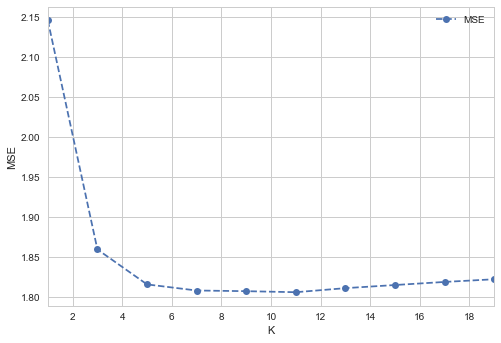

In [27]:
K_mse.plot(x='K', y='MSE',marker='o', linestyle='--',legend = "K vs MSE",xlim = (1,19))
plt.xlabel('K')
plt.ylabel('MSE')
#plt.figtext(.15, .01, "Fig. 1: Mean Standard Error as a function of the number of nearst neighbours (K).")
plt.savefig('reports/k_mse.jpg') 


In [28]:
##final KNN
neigh = KNeighborsRegressor(n_neighbors=optimal_k)
neigh.fit(X_train, y_train) 
y_pred = neigh.predict(X_test)
print("KNN RMSE on training set: ", rmse(y_test, y_pred))
print("KNN R2 on training set: ", r2_score(y_test, y_pred))

KNN RMSE on training set:  0.869450574563
KNN R2 on training set:  0.437341690149


### Lasso

In [29]:
#tunning parameter: alpha
alpha_options = [0.1,0.05,0.025,0.01,0.001,0.0001,0.00001]
cross_vals = []

for alp in alpha_options :
    LA = Lasso(alpha=alp, max_iter=50000)
    scores = cross_val_score(LA,
                             X_train, 
                              y_train, 
                             cv = 10, 
                             scoring='neg_mean_squared_error')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]
optimal_alpha = alpha_options[MSE.index(min(MSE))]

print("Optimal alpha is {0}".format(optimal_alpha))

## Draw alpha vs MSE
alpha_mse = pd.DataFrame(
    {"alpha": alpha_options,
     'MSE': MSE,
    })

alpha_mse_trans = alpha_mse.transpose()
alpha_mse_trans.head(5)

Optimal alpha is 0.1


,0,1,2,3,4,5,6
MSE,2.287454,2.327721,2.351679,2.369156,2.380555,2.380959,2.381004
alpha,0.100000,0.050000,0.025000,0.010000,0.001000,0.000100,0.000010


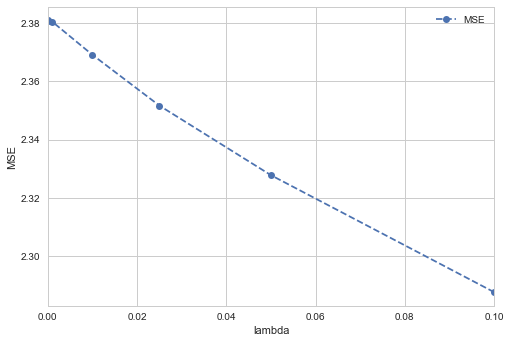

In [30]:
alpha_mse.plot(x='alpha', y='MSE',marker='o', linestyle='--',legend = "lambda vs MSE",xlim = (0.00001,0.1))
plt.xlabel('lambda')
plt.ylabel('MSE')
#plt.figtext(.15, .01, "Fig. 1: Mean Standard Error as a function of the number of nearst neighbours (K).")
plt.savefig('reports/alpha_mse.jpg')

In [31]:
##final Lasso

#found this best alpha through cross-validation
regr = Lasso(alpha=optimal_alpha, max_iter=100000)
regr.fit(X_train, y_train)

# run prediction on the training set to get a rough idea of how well it does
y_pred = regr.predict(X_test)
Lasso_rmse = rmse(y_test, y_pred)
print("Lasso score on training set: ", Lasso_rmse)
print("Lasso R2 on training set: ", r2_score(y_test, y_pred)) 

Lasso score on training set:  1.08059779612
Lasso R2 on training set:  0.130873294517


In [32]:
#PCA
pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, target, test_size=0.3, random_state=42)

regr = Lasso(alpha=optimal_alpha, max_iter=50000)
regr.fit(Xr_train, yr_train) 
yr_pred = regr.predict(Xr_test)
print("After applying PCA on the dataset")
PCA_rmse = rmse(yr_test, yr_pred)
print("Lasso RMSE on training set: ",PCA_rmse)
print("Lasso R2 on training set: ", r2_score(yr_test, yr_pred))

#  top 5 important features from random forest tree
X_m = X[['ZIP CODE', 'BLOCK','GROSS SQUARE FEET','LOT','BOROUGH']]
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_m, target, test_size=0.3, random_state=42)
regr = Lasso(alpha=optimal_alpha, max_iter=50000)
regr.fit(Xm_train, ym_train) 
ym_pred = regr.predict(Xm_test)
print("After picking top 5 important features")
top5_rmse = rmse(ym_test, ym_pred)
print("Lasso RMSE on training set: ", top5_rmse)
print("Lasso R2 on training set: ", r2_score(ym_test, ym_pred))


After applying PCA on the dataset
Lasso RMSE on training set:  1.09795086118
Lasso R2 on training set:  0.102734959316
After picking top 5 important features
Lasso RMSE on training set:  1.08759476075
Lasso R2 on training set:  0.119581512975


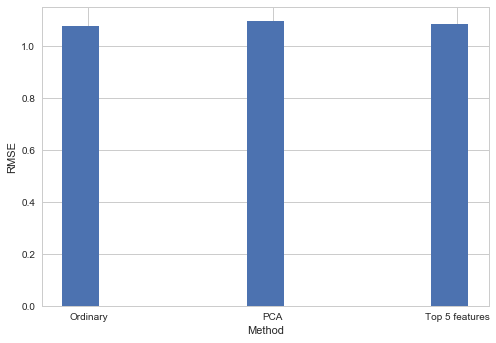

In [33]:
method =['Ordinary','PCA','Top 5 features']
rmse_pca = [Lasso_rmse, PCA_rmse,top5_rmse]
plt.xlabel("Method")
plt.ylabel("RMSE")

pos = np.arange(len(method))
width = 0.2     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticks(pos + (width / 5))
ax.set_xticklabels(method)
plt.bar(pos, rmse_pca, width, color='b')
plt.savefig('reports/method_rmse_pca.jpg')
plt.show()



### RandomForest

In [34]:
##tunning parameter: n_estimatiors, the number of trees
n_estimators_options = [100,200,300,400,500]
cross_vals = []

for n_tree in n_estimators_options :
    RF = RandomForestRegressor(n_estimators=n_tree, min_samples_split=2, max_features = 4)
    scores = cross_val_score(RF,
                             X_train, 
                              y_train, 
                             cv = 10, 
                             scoring='neg_mean_squared_error')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]
optimal_trees = n_estimators_options[MSE.index(min(MSE))]

print("Optimal number of tree is {0}".format(optimal_trees))




Optimal number of tree is 500


,0,1,2,3,4
MSE,1.57415,1.574011,1.570952,1.571678,1.570498
rf,100.00000,200.000000,300.000000,400.000000,500.000000


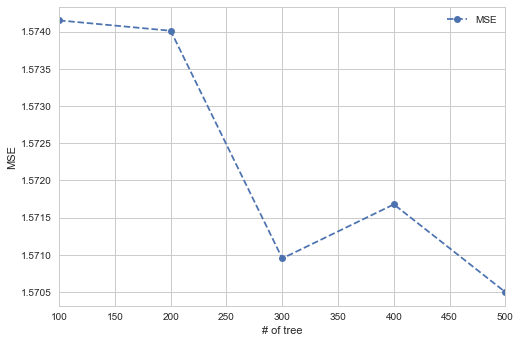

In [35]:
## Draw alpha vs MSE
rf_mse = pd.DataFrame(
    {"rf": n_estimators_options,
     'MSE': MSE,
    })

rf_mse.plot(x='rf', y='MSE', linestyle='--',marker='o')
plt.xlabel('# of tree')
plt.ylabel('MSE')
plt.savefig('reports/rf_mse.jpg')

rf_mse_trans = rf_mse.transpose()
rf_mse_trans.head(5)

In [36]:
#final RandomForest
regr = RandomForestRegressor(n_estimators=optimal_trees, min_samples_split=2,max_features = 4)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("RF score on training set: ", rmse(y_test, y_pred))
print("RF R2 on training set: ", r2_score(y_test, y_pred))

RF score on training set:  0.729734257227
RF R2 on training set:  0.603644938202


#### Feature Importance in Random Forest Model

/Users/lingyuan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


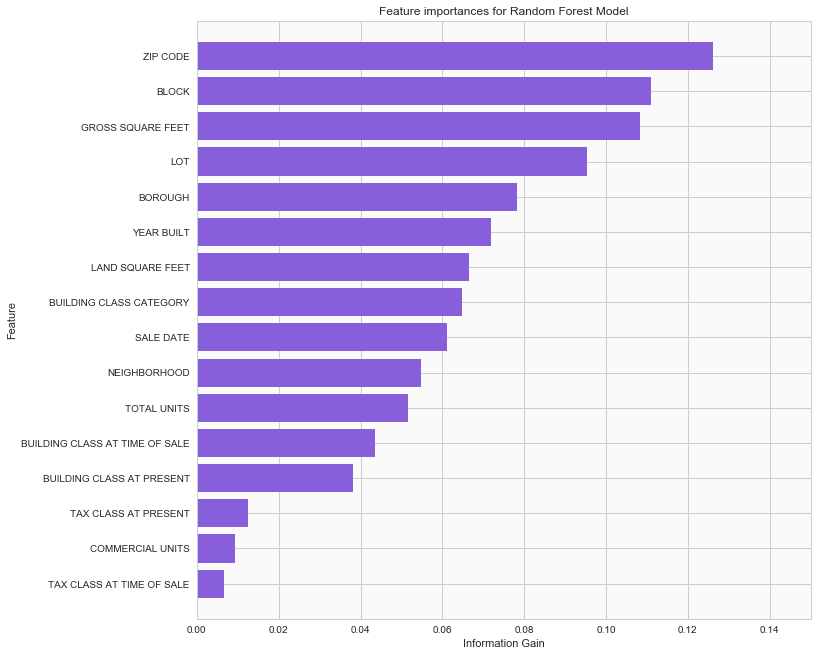

In [37]:
#Feature Importance in RandomForest Model

importancesRF = regr.feature_importances_
indicesRF = np.argsort(importancesRF)[::-1]
#print(indicesRF)

Header = list(X_train)
n = len(Header)
'''
for f in range(n):
    i = f
    print("%d. The feature '%s' \
	has a Information Gain of %f" % (f + 1,
				Header[indicesRF[i]],
				importancesRF[indicesRF[f]]))
 '''   
indRf = sorted(importancesRF) # Sort by Decreasing order
index = np.arange(n)

feature_space = []
for i in range(n-1, -1, -1):
    feature_space.append(Header[indicesRF[i]])
    
f, ax = plt.subplots(figsize=(11, 11))

ax.set_axis_bgcolor('#fafafa')
plt.title('Feature importances for Random Forest Model')
plt.barh(index, indRf,
        align="center", 
        color = '#875FDB')

plt.yticks(index, feature_space)
plt.ylim(-1, n)
plt.xlim(0, 0.15)
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.savefig('reports/rf_importance.jpg')

plt.show()
